<a href="https://colab.research.google.com/github/robinjmf/Music_Classification/blob/main/genre_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub
import shutil
import os


# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)


# Define the target path
target_path = '/kaggle/input/gtzan-dataset-music-genre-classification'
os.makedirs(target_path, exist_ok=True)

# Move files from the download location to the target path
shutil.move(path, target_path)

print("Dataset successfully moved to:", target_path)

# print("Path to dataset files:", download_path)


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


Error: Destination path '/kaggle/input/gtzan-dataset-music-genre-classification/1' already exists

# GTZAN - Deep Learning

`Music Genre Classification Problem`. Experts have been trying for a long time to understand sound & what differentiates one from another. How to visualize sound. What makes one tone different from another.

We are going to analyze the features extracted from the GTZAN dataset and build different type of ensemble models to see how better we can differentiate one genre from another.

Our Datasets contains 10 genres:-
- Blues
- Classical
- Country
- Disco
- Hiphop
- Jazz
- Metal
- Pop
- Reggae
- Rock


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
import math
seed = 12
np.random.seed(seed)

# CNN
Using keras layers of Conv2D, MaxPool2D, BatchNormalization.

CNN layers takes input primarily in 3D shape, so we again have to prepare the dataset in the form and for that, I have used np.newaxis function which adds a column/layer in the data

## Make MFCC features and Log Mel Spectrum

In [5]:

dataset_path = r"/kaggle/input/gtzan-dataset-music-genre-classification/1/Data/genres_original"
mfcc_json_path = r"mfcc_data.json"
logmel_json_path = r"logmel_data.json"
sample_rate = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [4]:
import os
import librosa
import json
import math
from IPython.display import clear_output

SAMPLE_RATE = 22050
SAMPLES_PER_TRACK = SAMPLE_RATE * 30  # Assuming 30 seconds per track

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048,
              hop_length=512, num_segments=5, selected_genres=None):
    # Data storage dictionary
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(SAMPLES_PER_TRACK / num_segments)  # ps = per segment
    expected_vects_ps = math.ceil(samples_ps / hop_length)

    # Loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # Ensuring not at root
        if dirpath is not dataset_path:
            # Save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]

            # Check if the genre is in the selected genres list (if provided)
            if selected_genres is None or semantic_label in selected_genres:
                data["mapping"].append(semantic_label)
                print(f"Processing: {semantic_label}")

                # Process files for specific genre
                for f in filenames:
                    if f == "jazz.00054.wav":
                        # As librosa only reads files <1Mb
                        continue
                    else:
                        # Load audio file
                        file_path = os.path.join(dirpath, f)
                        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                        for s in range(num_segments):
                            start_sample = samples_ps * s
                            finish_sample = start_sample + samples_ps

                            mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                                        sr=sr,
                                                        n_fft=n_fft,
                                                        n_mfcc=n_mfcc,
                                                        hop_length=hop_length)

                            mfcc = mfcc.T

                            # Store MFCC if it has the expected length
                            if len(mfcc) == expected_vects_ps:
                                data["mfcc"].append(mfcc.tolist())
                                data["labels"].append(i - 1)
                                print(f"{file_path}, segment: {s + 1}")

    # Save the data as a JSON file
    with open(json_path, "w") as f:
        json.dump(data, f, indent=4)

# Example usage:
# save_mfcc('dataset_path', 'output.json', selected_genres=['classical', 'rock'])


In [5]:
import os
import librosa
import json
import math
import numpy as np

def save_log_mel_spectrogram(dataset_path, json_path, n_mels=128, n_fft=2048,
                             hop_length=512, num_segments=5, selected_genres=None):
    data = {"mapping": [], "log_mel": [], "labels": []}
    samples_ps = int(SAMPLES_PER_TRACK / num_segments)
    expected_vects_ps = math.ceil(samples_ps / hop_length)  # Adjusted

    for dirpath, dirnames, filenames in os.walk(dataset_path):
        if dirpath != dataset_path:
            semantic_label = os.path.basename(dirpath)
            if selected_genres is None or semantic_label in selected_genres:
                data["mapping"].append(semantic_label)
                print(f"Processing genre: {semantic_label} ({len(filenames)} files)")

                for f in filenames:
                    if not f.endswith(".wav"):
                        continue

                    file_path = os.path.join(dirpath, f)
                    try:
                        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                    except Exception as e:
                        print(f"🚨 Error loading {file_path}: {e}")
                        continue

                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps
                        mel_spectrogram = librosa.feature.melspectrogram(
                            y=signal[start_sample:finish_sample],
                            sr=sr, n_fft=n_fft,
                            hop_length=hop_length, n_mels=n_mels
                        )
                        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max).T

                        # Fix 1: Accept shorter segments (at least 80% of expected length)
                        if len(log_mel_spectrogram) >= expected_vects_ps * 0.8:
                            # Fix 2: Pad if needed
                            if len(log_mel_spectrogram) < expected_vects_ps:
                                pad_width = expected_vects_ps - len(log_mel_spectrogram)
                                log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, pad_width), (0, 0)), mode='constant')

                            data["log_mel"].append(log_mel_spectrogram.tolist())
                            # Ensure consistent indexing
                            if semantic_label not in data["mapping"]:
                              data["mapping"].append(semantic_label)

                            label = data["mapping"].index(semantic_label)  # Assign correct index
                            data["labels"].append(label)

                            print(f"✅ Saved {file_path}, segment {s+1} (New Shape: {log_mel_spectrogram.shape})")
                        else:
                            print(f"🚨 Skipping {file_path}, segment {s+1} (Too short, Shape: {log_mel_spectrogram.shape})")

    if len(data["log_mel"]) > 0:
        print(f"✅ Saving {len(data['log_mel'])} samples to {json_path}...")
        with open(json_path, "w") as f:
            json.dump(data, f, indent=4)
    else:
        print("🚨 No data to save! JSON file will remain empty.")


In [15]:
import os
import librosa
import h5py
import math
import numpy as np

# Ensure that SAMPLES_PER_TRACK is defined (e.g., for 30 seconds at 22050 Hz)
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def save_log_mel_spectrogram_hdf5(dataset_path, hdf5_path, n_mels=128, n_fft=2048,
                                  hop_length=512, num_segments=5, selected_genres=None):
    """
    Process audio files from dataset_path to extract log Mel spectrogram features,
    and save the results into an HDF5 file at hdf5_path.

    The data saved includes:
      - "mapping": a list of genre names (one per directory)
      - "log_mel": a 3D array of spectrograms (each of shape (expected_vects_ps, n_mels))
      - "labels": an array of integer labels corresponding to each spectrogram

    Args:
        dataset_path (str): Path to the dataset folder containing genre subdirectories.
        hdf5_path (str): Path to save the HDF5 file.
        n_mels (int): Number of Mel bands.
        n_fft (int): FFT window size.
        hop_length (int): Hop length.
        num_segments (int): Number of segments to split each track.
        selected_genres (list or None): List of genres to process (if None, process all).
    """
    data = {"mapping": [], "log_mel": [], "labels": []}
    samples_ps = int(SAMPLES_PER_TRACK / num_segments)
    expected_vects_ps = math.ceil(samples_ps / hop_length)

    # Normalize selected_genres to lowercase for consistent comparison.
    if selected_genres is not None:
        selected_genres = [genre.lower() for genre in selected_genres]

    # --- Pre-collect all valid genre names ---
    genre_set = set()
    for dirpath, dirnames, filenames in os.walk(dataset_path):
        if dirpath == dataset_path:
            continue
        semantic_label = os.path.basename(dirpath).lower()  # Normalize folder name
        if selected_genres is None or semantic_label in selected_genres:
            genre_set.add(semantic_label)
    # Create a sorted mapping for consistency.
    data["mapping"] = sorted(list(genre_set))
    print(f"✅ Genre Mapping: {data['mapping']}")

    # --- Process Each Genre Folder ---
    for dirpath, dirnames, filenames in os.walk(dataset_path):
        if dirpath == dataset_path:
            continue
        semantic_label = os.path.basename(dirpath).lower()  # Normalize folder name
        if semantic_label not in data["mapping"]:
            continue  # Skip genres not in the mapping

        print(f"Processing genre: {semantic_label} ({len(filenames)} files)")
        for f in filenames:
            if not f.endswith(".wav"):
                continue
            file_path = os.path.join(dirpath, f)
            try:
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            except Exception as e:
                print(f"🚨 Error loading {file_path}: {e}")
                continue
            for s in range(num_segments):
                start_sample = samples_ps * s
                finish_sample = start_sample + samples_ps
                mel_spectrogram = librosa.feature.melspectrogram(
                    y=signal[start_sample:finish_sample],
                    sr=sr, n_fft=n_fft,
                    hop_length=hop_length, n_mels=n_mels
                )
                log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max).T

                # Accept segments that are at least 80% of the expected length.
                if len(log_mel_spectrogram) >= expected_vects_ps * 0.8:
                    # Pad the segment if it's shorter than expected.
                    if len(log_mel_spectrogram) < expected_vects_ps:
                        pad_width = expected_vects_ps - len(log_mel_spectrogram)
                        log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, pad_width), (0, 0)), mode='constant')

                    # Append the processed spectrogram.
                    data["log_mel"].append(log_mel_spectrogram.tolist())
                    # Get the label (genre index) from the mapping.
                    label = data["mapping"].index(semantic_label)
                    data["labels"].append(label)
                    print(f"✅ Saved {file_path}, segment {s+1} (Shape: {log_mel_spectrogram.shape}, Label: {label})")
                else:
                    print(f"🚨 Skipping {file_path}, segment {s+1} (Too short, Shape: {log_mel_spectrogram.shape})")

    # --- Save to HDF5 ---
    if len(data["log_mel"]) > 0:
        print(f"✅ Saving {len(data['log_mel'])} samples to {hdf5_path}...")
        # Convert lists to numpy arrays.
        log_mel_array = np.array(data["log_mel"])   # Shape: (num_samples, expected_vects_ps, n_mels)
        labels_array = np.array(data["labels"], dtype=np.int32)
        mapping_array = np.array(data["mapping"], dtype="S")  # Save mapping as ASCII byte strings.

        with h5py.File(hdf5_path, "w") as hf:
            hf.create_dataset("log_mel", data=log_mel_array, compression="gzip")
            hf.create_dataset("labels", data=labels_array, compression="gzip")
            hf.create_dataset("mapping", data=mapping_array, compression="gzip")
        print("✅ Data successfully saved to HDF5!")
    else:
        print("🚨 No data to save! HDF5 file will remain empty.")


In [7]:
#genres that we want to classify
genres = ["classical",
"disco",
"blues",
"country",
"hiphop",
"jazz",
"metal",
"pop",
"reggae",
"rock"]

# genres = ["classical", "disco"]

len(genres)

10

In [7]:
# save_mfcc(dataset_path, mfcc_json_path, num_segments=10)
# clear_output()

In [8]:
# save_log_mel_spectrogram(dataset_path, logmel_json_path, num_segments=5, selected_genres=genres)
# # clear_output()

In [16]:
# Replace with your dataset directory path
hdf5_path = "logmel_data.h5"            # Output HDF5 file
selected_genres = ["classical", "disco", "blues", "country", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

save_log_mel_spectrogram_hdf5(dataset_path, hdf5_path, n_mels=128, n_fft=2048,
                              hop_length=512, num_segments=5, selected_genres=selected_genres)


Streaming output truncated to the last 5000 lines.
✅ Saved /kaggle/input/gtzan-dataset-music-genre-classification/1/Data/genres_original/pop/pop.00003.wav, segment 3 (Shape: (259, 128), Label: 7)
✅ Saved /kaggle/input/gtzan-dataset-music-genre-classification/1/Data/genres_original/pop/pop.00003.wav, segment 4 (Shape: (259, 128), Label: 7)
✅ Saved /kaggle/input/gtzan-dataset-music-genre-classification/1/Data/genres_original/pop/pop.00003.wav, segment 5 (Shape: (259, 128), Label: 7)
✅ Saved /kaggle/input/gtzan-dataset-music-genre-classification/1/Data/genres_original/pop/pop.00067.wav, segment 1 (Shape: (259, 128), Label: 7)
✅ Saved /kaggle/input/gtzan-dataset-music-genre-classification/1/Data/genres_original/pop/pop.00067.wav, segment 2 (Shape: (259, 128), Label: 7)
✅ Saved /kaggle/input/gtzan-dataset-music-genre-classification/1/Data/genres_original/pop/pop.00067.wav, segment 3 (Shape: (259, 128), Label: 7)
✅ Saved /kaggle/input/gtzan-dataset-music-genre-classification/1/Data/genres_or

In [ ]:
# from sklearn.model_selection import train_test_split


# def prepare_dataset(path, test_size, validation_size):
#     X, y, _ = load_data(path)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
#     X_train = X_train[..., np.newaxis]
#     X_val = X_val[..., np.newaxis]
#     X_test = X_test[..., np.newaxis]

#     return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(mfcc,0.25, 0.2)

In [ ]:
# input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
# print(input_shape)

In [9]:
!pip install ijson

In [26]:
# import ijson

# with open("logmel_data.json", "r") as f:
#     top_keys = set()  # Store found keys
#     for prefix, event, value in ijson.parse(f):
#         if prefix and "." not in prefix:  # Top-level keys only
#             top_keys.add(prefix)
#         if len(top_keys) >= 5:  # Stop early after 5 keys
#             break

# print("Top-Level Keys:", top_keys)


In [30]:
!ps aux --sort=-%mem | head -n 10


USER         PID %CPU %MEM    VSZ   RSS TTY      STAT START   TIME COMMAND
root       19424 18.6 25.6 6340844 3406212 ?     Ssl  19:17  15:27 /usr/bin/python3 -m colab_kernel_
root       35971 12.8  2.8 1152248 385328 ?      Sl   20:26   1:49 node /datalab/web/pyright/pyright
root          93  0.1  0.7 366104 102068 ?       Sl   17:57   0:17 /usr/bin/python3 /usr/local/bin/j
root           6  0.2  0.3 913496 47648 ?        Sl   17:57   0:24 /tools/node/bin/node /datalab/web
root          72  0.0  0.3  65976 40600 ?        S    17:57   0:02 python3 /usr/local/bin/colab-file
root       19473  0.0  0.1 545972 18236 ?        Sl   19:17   0:04 /usr/bin/python3 /usr/local/lib/p
root          19  0.4  0.1 1238100 15444 ?       Sl   17:57   0:41 /usr/colab/bin/kernel_manager_pro
root       35965  0.1  0.0 1240984 10716 ?       Sl   20:26   0:00 /usr/colab/bin/language_service -
root          94  0.1  0.0 1230316 8452 ?        Sl   17:57   0:09 /usr/local/bin/dap_multiplexer --


In [31]:
# with open("logmel_data.json", "r") as f:
#     data = json.load(f)


# # Fetch correct genre mapping from JSON
# genre_mapping = data["mapping"]

# # Get available genres dynamically
# unique_labels = set(data["labels"])
# available_genres = [genre_mapping[label] for label in unique_labels]

# print(f"Available genre labels: {unique_labels}")
# print(f"Available genre names: {available_genres}")

import ijson

mapping = []
unique_labels = set()

with open("logmel_data.json", "r") as f:
    parser = ijson.items(f, "mapping.item")
    mapping = list(parser)  # Streams & collects all genre names

with open("logmel_data.json", "r") as f:
    parser = ijson.items(f, "labels.item")
    unique_labels = set(parser)  # Streams & collects unique labels

# Convert label indices to actual genre names
available_genres = [mapping[label] for label in unique_labels if label < len(mapping)]

print(f"Available genre labels: {unique_labels}")
print(f"Available genre names: {available_genres}")


Available genre labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Available genre names: ['pop', 'hiphop', 'rock', 'metal', 'disco', 'country', 'blues', 'jazz', 'reggae', 'classical']


In [20]:
# import json
# import numpy as np
# from tensorflow.keras.utils import to_categorical

# def split_data_generator(dataset_path, selected_genres=None, batch_size=64, split="train",
#                          test_size=0.25, validation_size=0.2, data_key="mfcc", return_label_map=False):
#     """
#     A generator to load batches of data dynamically from a JSON file.

#     Args:
#         dataset_path (str): Path to the JSON file.
#         selected_genres (list): List of genre names to filter the data.
#         batch_size (int): Number of samples per batch.
#         split (str): "train", "validation", or "test".
#         test_size (float): Fraction of data to use for testing.
#         validation_size (float): Fraction of training data to use for validation.
#         data_key (str): Key to access features in the JSON file ("mfcc" or "log_mel").
#         return_label_map (bool): If True, returns label_map along with batch data.

#     Yields:
#         - (inputs_batch, targets_batch) for model training
#         - (inputs_batch, targets_batch, label_map) if `return_label_map=True`
#     """
#     with open(dataset_path, "r") as f:
#         data = json.load(f)

#     total_samples = len(data[data_key])
#     indices = np.arange(total_samples)

#     # Shuffle indices to ensure randomness
#     np.random.shuffle(indices)

#     # Split dataset
#     num_test_samples = int(test_size * total_samples)
#     num_validation_samples = int(validation_size * (total_samples - num_test_samples))

#     if split == "test":
#         split_indices = indices[:num_test_samples]
#     elif split == "validation":
#         split_indices = indices[num_test_samples:num_test_samples + num_validation_samples]
#     else:  # "train"
#         split_indices = indices[num_test_samples + num_validation_samples:]

#     # **Fix 1: Ensure There is Data to Process**
#     if len(split_indices) == 0:
#         print(f"🚨 No data available for split: {split}. Exiting generator.")
#         return  # Stop the generator if no data is available

#     # Prepare label_map for selected genres
#     if selected_genres is not None:
#         # Load mapping from dataset
#         genre_mapping = data["mapping"]

#         # Get selected genre indices dynamically
#         selected_indices = [genre_mapping.index(genre) for genre in selected_genres if genre in genre_mapping]
#         print(f"Selected genre indices: {selected_indices}")

#         label_map = {old_label: idx for idx, old_label in enumerate(selected_indices)}
#     else:
#         label_map = {i: i for i in range(10)}

#     while True:  # Infinite loop for batch generation
#         data_found = False  # Flag to check if data was found

#         for start_idx in range(0, len(split_indices), batch_size):
#             end_idx = min(start_idx + batch_size, len(split_indices))
#             batch_indices = split_indices[start_idx:end_idx]

#             inputs_batch = np.array([data[data_key][i] for i in batch_indices])
#             targets_batch = np.array([data["labels"][i] for i in batch_indices])

#             if selected_genres is not None:
#                 # Filter data to include only selected genres
#                 mask = np.isin(targets_batch, selected_indices)

#                 # **Fix 2: Ensure Filtered Data is Not Empty**
#                 if not np.any(mask):
#                     print("🚨 No data left after filtering by selected genres! Skipping batch.")
#                     continue  # Skip to the next batch instead of hanging

#                 inputs_batch = inputs_batch[mask]
#                 targets_batch = targets_batch[mask]

#                 # Adjust targets using the label_map
#                 targets_batch = np.array([label_map[target] for target in targets_batch])

#             # **Fix 3: Ensure Batch is Not Empty Before Yielding**
#             if inputs_batch.shape[0] == 0:
#                 print("🚨 Empty batch detected! Skipping...")
#                 continue

#             data_found = True  # Data successfully found
#             targets_batch = to_categorical(targets_batch, num_classes=len(label_map))

#             # Expand dimensions for CNN input
#             inputs_batch = np.expand_dims(inputs_batch, axis=-1)

#             # ✅ Return label_map only if `return_label_map=True`
#             if return_label_map:
#                 yield inputs_batch, targets_batch, label_map
#             else:
#                 yield inputs_batch, targets_batch

#         # **Fix 4: Exit the Loop if No Data Was Found in the Entire Pass**
#         if not data_found:
#             print("🚨 No valid data found in entire dataset. Stopping generator.")
#             break  # Exit the while loop


import json
import numpy as np
from tensorflow.keras.utils import to_categorical

def split_data_generator(dataset_path, file_format="json", selected_genres=None, batch_size=64,
                         split="train", test_size=0.25, validation_size=0.2,
                         data_key="mfcc", return_label_map=False):
    """
    A generator to load batches of data dynamically from a JSON or HDF5 file.

    Args:
        dataset_path (str): Path to the data file (JSON or HDF5).
        file_format (str): "json" or "h5" to indicate the file format.
        selected_genres (list): List of genre names to filter the data.
        batch_size (int): Number of samples per batch.
        split (str): "train", "validation", or "test".
        test_size (float): Fraction of data to use for testing.
        validation_size (float): Fraction of training data to use for validation.
        data_key (str): Key to access features in the file ("mfcc" or "log_mel").
        return_label_map (bool): If True, yield (inputs_batch, targets_batch, label_map).

    Yields:
        For training: (inputs_batch, targets_batch) or (inputs_batch, targets_batch, label_map)
    """
    if file_format.lower() == "json":
        with open(dataset_path, "r") as f:
            data = json.load(f)
        total_samples = len(data[data_key])
    elif file_format.lower() == "h5":
        import h5py
        hf = h5py.File(dataset_path, "r")
        # For HDF5, we load mapping fully; the heavy arrays are kept as h5py datasets.
        data = {}
        data["mapping"] = [x.decode("utf-8") for x in hf["mapping"][:]]
        data[data_key] = hf[data_key]   # This is an h5py dataset that supports slicing.
        data["labels"] = hf["labels"]     # This is an h5py dataset.
        total_samples = data[data_key].shape[0]
    else:
        raise ValueError("Unsupported file format. Use 'json' or 'h5'.")

    # Create indices and shuffle
    indices = np.arange(total_samples)
    np.random.shuffle(indices)

    # Split dataset indices
    num_test_samples = int(test_size * total_samples)
    num_validation_samples = int(validation_size * (total_samples - num_test_samples))
    if split == "test":
        split_indices = indices[:num_test_samples]
    elif split == "validation":
        split_indices = indices[num_test_samples:num_test_samples + num_validation_samples]
    else:  # "train"
        split_indices = indices[num_test_samples + num_validation_samples:]

    if len(split_indices) == 0:
        print(f"🚨 No data available for split: {split}. Exiting generator.")
        return

    # Prepare label_map for selected genres
    if selected_genres is not None:
        # Normalize selected genres to lowercase
        selected_genres = [genre.lower() for genre in selected_genres]
        # For both file types, use the mapping from the data.
        if file_format.lower() == "json":
            genre_mapping = [g.lower() for g in data["mapping"]]
        else:  # h5
            genre_mapping = [g.lower() for g in data["mapping"]]
        # Get indices in genre_mapping corresponding to selected genres.
        selected_indices = [genre_mapping.index(genre) for genre in selected_genres if genre in genre_mapping]
        print(f"Selected genre indices: {selected_indices}")
        label_map = {old_label: idx for idx, old_label in enumerate(selected_indices)}
    else:
        if file_format.lower() == "json":
            label_map = {i: i for i in range(10)}
        else:
            label_map = {i: i for i in range(len(data["mapping"]))}
        selected_indices = list(label_map.keys())

    while True:
        data_found = False
        for start_idx in range(0, len(split_indices), batch_size):
            end_idx = min(start_idx + batch_size, len(split_indices))
            batch_indices = split_indices[start_idx:end_idx]

            if file_format.lower() == "json":
                inputs_batch = np.array([data[data_key][i] for i in batch_indices])
                targets_batch = np.array([data["labels"][i] for i in batch_indices])
            else:  # h5: sort the batch_indices because h5py requires indices in increasing order.
                sorted_indices = np.sort(batch_indices)
                inputs_batch = np.array(data[data_key][sorted_indices])
                targets_batch = np.array(data["labels"][sorted_indices])

            if selected_genres is not None:
                mask = np.isin(targets_batch, selected_indices)
                if not np.any(mask):
                    print("🚨 No data left after filtering by selected genres! Skipping batch.")
                    continue
                inputs_batch = inputs_batch[mask]
                targets_batch = targets_batch[mask]
                targets_batch = np.array([label_map[target] for target in targets_batch])

            if inputs_batch.shape[0] == 0:
                print("🚨 Empty batch detected! Skipping...")
                continue

            data_found = True
            targets_batch = to_categorical(targets_batch, num_classes=len(label_map))
            inputs_batch = np.expand_dims(inputs_batch, axis=-1)

            if return_label_map:
                yield inputs_batch, targets_batch, label_map
            else:
                yield inputs_batch, targets_batch

        if not data_found:
            print("🚨 No valid data found in entire dataset. Stopping generator.")
            break

    if file_format.lower() == "h5":
        hf.close()


In [21]:
# # Train generator
# train_gen = split_data_generator(
#     dataset_path="logmel_data.json",
#     selected_genres=genres,
#     batch_size=16,
#     split="train",
#     test_size=0.25,
#     validation_size=0.2,
#     data_key="log_mel"  # Access Log Mel Spectrogram features
# )

# # Validation generator
# val_gen = split_data_generator(
#     dataset_path="logmel_data.json",
#     selected_genres=genres,
#     batch_size=16,
#     split="validation",
#     test_size=0.25,
#     validation_size=0.2,
#     data_key="log_mel"
# )


train_gen = split_data_generator(
    dataset_path="logmel_data.h5",   # Use the HDF5 file here
    file_format="h5",                # Specify that the file format is HDF5
    selected_genres=genres,
    batch_size=16,
    split="train",
    test_size=0.25,
    validation_size=0.2,
    data_key="log_mel"               # Access Log Mel Spectrogram features
)

val_gen = split_data_generator(
    dataset_path="logmel_data.h5",   # Use the HDF5 file here
    file_format="h5",                # Specify that the file format is HDF5
    selected_genres=genres,
    batch_size=16,
    split="validation",
    test_size=0.25,
    validation_size=0.2,
    data_key="log_mel"               # Access Log Mel Spectrogram features
)

inputs_batch, targets_batch = next(train_gen)
print("Batch shape (HDF5):", inputs_batch.shape)


Selected genre indices: [1, 3, 0, 2, 4, 5, 6, 7, 8, 9]
Batch shape (HDF5): (16, 259, 128, 1)


In [ ]:
# # Try fetching one batch
# print("Fetching batch 1...")
# inputs_batch, targets_batch = next(train_gen)
# print(f"Batch 1 loaded successfully! Shape: {inputs_batch.shape}")

Fetching batch 1...


In [22]:
input_shape = inputs_batch.shape[1:]  # Exclude batch dimension
print("Input Shape:", input_shape)

Input Shape: (259, 128, 1)


In [23]:
# model = k.models.Sequential()
# model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
# model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
# model.add(BatchNormalization())

# model.add(Conv2D(32, (3, 3), activation = "relu"))
# model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
# model.add(BatchNormalization())

# model.add(Conv2D(32, (2, 2), activation = "relu"))
# model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
# model.add(BatchNormalization())

# model.add(Conv2D(16, (1, 1), activation = "relu"))
# model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
# model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(64, activation="relu"))
# model.add(Dropout(0.3))
# model.add(Dense(10, activation="softmax"))

# model.summary()

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

num_classes = len(genres)  # Dynamically adjust output classes

model = Sequential()
model.add(Conv2D(64, (3, 3), activation="relu", input_shape=input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation="relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation="relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation="softmax"))  # ✅ Dynamically adjusted

model.summary()


# Compile the model
new_optimizer = Adam()
model.compile(optimizer=new_optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 257, 126, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 129, 63, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 129, 63, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 127, 61, 32)         │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 31, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 63, 30, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 15, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 15, 16)          │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 8, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 8, 16)           │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,122 (609.85 KB)

 Trainable params: 155,834 (608.73 KB)

 Non-trainable params: 288 (1.12 KB)

In [24]:
# checking and matching between train and validation generator

inputs_batch, targets_batch = next(train_gen)
print("Train batch shape:", inputs_batch.shape, targets_batch.shape)

inputs_batch, targets_batch = next(val_gen)
print("Validation batch shape:", inputs_batch.shape, targets_batch.shape)


Train batch shape: (16, 259, 128, 1) (16, 10)
Selected genre indices: [1, 3, 0, 2, 4, 5, 6, 7, 8, 9]
Validation batch shape: (16, 259, 128, 1) (16, 10)


In [25]:
# new_optimizer = k.optimizers.Adam()
# model.compile(optimizer=new_optimizer,
#               loss="categorical_crossentropy",
#               metrics=["accuracy"])

# hist = model.fit(X_train, y_train,
#                  validation_data = (X_val, y_val),
#                  epochs = 40,
#                  batch_size = 32)


# Train the model
steps_per_epoch = 50  # Adjust based on dataset size
validation_steps = 25  # Adjust based on dataset size

hist = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 395s 8s/step - accuracy: 0.1924 - loss: 2.4831 - val_accuracy: 0.1625 - val_loss: 7.3582
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 443s 9s/step - accuracy: 0.3115 - loss: 1.8280 - val_accuracy: 0.1310 - val_loss: 5.4527
Epoch 3/10
24/50 ━━━━━━━━━━━━━━━━━━━━ 2:21 5s/step - accuracy: 0.3676 - loss: 1.7801

KeyboardInterrupt: 

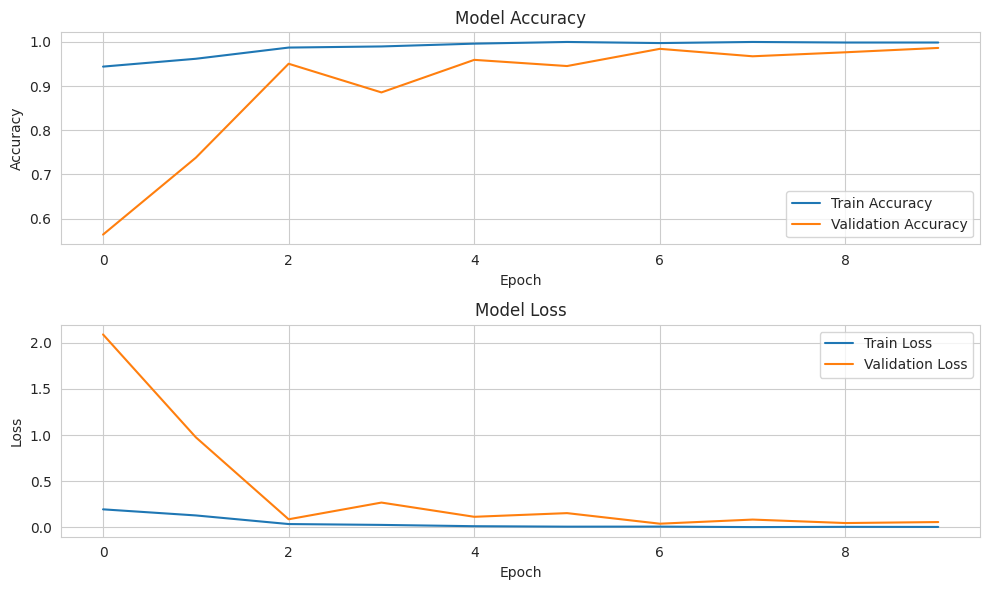

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    """Plots training & validation loss and accuracy."""
    fig, axs = plt.subplots(2, figsize=(10, 6))

    # Plot accuracy
    axs[0].plot(history.history['accuracy'], label="Train Accuracy")
    axs[0].plot(history.history['val_accuracy'], label="Validation Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_title("Model Accuracy")
    axs[0].legend()

    # Plot loss
    axs[1].plot(history.history['loss'], label="Train Loss")
    axs[1].plot(history.history['val_loss'], label="Validation Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_title("Model Loss")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


plot_history(hist)


In [ ]:
test_gen = split_data_generator(
    dataset_path="logmel_data.json",
    selected_genres=genres,
    batch_size=16,
    split="test",  # Use the test split
    test_size=0.25,  # Ensure test split exists
    validation_size=0.2,
    data_key="log_mel"
)

test_steps = 25  # Adjust based on dataset size

# Evaluate on test set
test_error, test_accuracy = model.evaluate(test_gen, steps=test_steps, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")


Selected genre indices: [2, 1, 0]
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 390ms/step - accuracy: 0.9796 - loss: 0.0328
Test Accuracy: 0.9872


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_gen, label_map, test_steps=50):
    """
    Plots a confusion matrix for the model's predictions on test data.

    Args:
        model: Trained model.
        test_gen: Data generator for test data.
        label_map: Dictionary mapping labels to genre indices.
        test_steps: Number of steps (batches) to run for evaluation.
    """
    # Get test data and predictions
    y_true = []
    y_pred = []

    for _ in range(test_steps):
        X_batch, y_batch = next(test_gen)  # Fetch batch
        predictions = model.predict(X_batch)  # Get model predictions

        y_true.extend(np.argmax(y_batch, axis=1))  # Convert one-hot to label indices
        y_pred.extend(np.argmax(predictions, axis=1))  # Get predicted labels

    # Convert indices back to genre names
    genre_labels = list(label_map.keys())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()



In [ ]:
# Create test generator with label_map
test_gen = split_data_generator(
    dataset_path="logmel_data.json",
    selected_genres=["classical", "disco", "metal"],  # Same genres as training
    batch_size=16,
    split="test",
    test_size=0.25,
    validation_size=0.2,
    data_key="log_mel",
    return_label_map=True  # Get label_map
)

# Get first batch to extract label_map
_, _, label_map = next(test_gen)

# Reinitialize test generator (because next() consumes one batch)
test_gen = split_data_generator(
    dataset_path="logmel_data.json",
    selected_genres=["classical", "disco", "metal"],
    batch_size=16,
    split="test",
    test_size=0.25,
    validation_size=0.2,
    data_key="log_mel"
)

# Plot the confusion matrix
plot_confusion_matrix(model, test_gen, label_map, test_steps=25)
